In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from sklearn.preprocessing import OrdinalEncoder
from scipy.ndimage import zoom
from scipy.spatial.distance import cdist
from pulp import *
from ortools.linear_solver import pywraplp
from tqdm import tqdm

In [2]:
dfcluster = pd.read_csv('./dataset/dfcluster_ConvLSTM_25.csv')
df_dist = pd.read_csv('./dataset/Distance_Matrix.csv')
df_dist_new = pd.read_csv('./dataset/Distance_Matrix_New2.csv')

In [3]:
encoder = OrdinalEncoder()

latlonpair = pd.DataFrame(encoder.fit_transform(dfcluster[['Latitude','Longitude']].values), columns=['lat_encode','long_encode'])
latlonpair['lat_encode'] = abs(latlonpair['lat_encode'] - latlonpair['lat_encode'].max())
dfcluster[['Latitude','Longitude']] = latlonpair
selected_pix = dfcluster[['Longitude','Latitude']].astype(int).values
dfcluster['pix'] = 1

In [4]:
bio_images = []
bio_df  =[]

In [5]:
init_shape = (75,60)
target_shape = (15, 12)
for i,year in enumerate(['2018','2019','pix']):
    image = Image.new('F', init_shape)
    draw = ImageDraw.Draw(image)
    for index, row in dfcluster.iterrows():
        x = int(row['Longitude'])
        y = int(row['Latitude'])
        value = row[str(year)]

        draw.point((x, y), fill=(value))

    scale_factor = np.array(target_shape) / np.array(init_shape)
    resized_array = zoom(image, zoom=scale_factor, order=1)
    bio_images.append(np.array(resized_array))

    np_images = np.array(resized_array)
    cols, rows = target_shape
    x_coords = np.repeat(np.arange(rows), cols)
    y_coords = np.tile(np.arange(cols), rows)
    values = np_images.flatten()
    df = pd.DataFrame({'Latitude': x_coords, 'Longitude': y_coords, 'value': values})
    df = df[df['value']>0]
    df['Latitude'] = abs(df['Latitude'] - df['Latitude'].max())
    bio_df.append(df)

bio_images = np.array(bio_images)

In [6]:
base_df = bio_df[2].reset_index(drop=True).reset_index().drop('value',axis=1)
dfcluster_new = base_df.merge(bio_df[0], how='left', on=['Latitude','Longitude']).merge(bio_df[1], how='left', on=['Latitude','Longitude'])
dfcluster_new = dfcluster_new.rename(columns={'value_x':'2018','value_y':'2019','index':'Index'}).fillna(0)

In [ ]:
# df = dfcluster_new.drop(['2018','2019'],axis=1).set_index('Index')
# coordinates = df[['Longitude', 'Latitude']].values
# distance_matrix = cdist(coordinates, coordinates, metric='euclidean')
# df_dist_new = pd.DataFrame(distance_matrix, index=df.index, columns=df.index).reset_index(drop=True)
# ratio = df_dist['0'][2417]/df_dist_new[0][91]
# df_dist_new = df_dist_new*ratio

In [7]:
def calc_loss(loss) :
    C = loss['transport'][-1]
    U = loss['underutil'][-1]
    print(f'Transport Loss : {C}')
    print(f'Underutil Loss : {U}')
    print(f'Overall Loss : {C+U}')
    return C, U, (C*0.001)+U

def plot_loss(loss, ax=None):
    sns.lineplot(np.array(loss['transport']) * 0.001, label='Transport Loss (scaled)', ax=ax)
    sns.lineplot(np.array(loss['underutil']), label='Underutilization Loss', ax=ax)
    sns.lineplot(np.array(loss['underutil']) + np.array(loss['transport']) * 0.001, label='Total Loss', ax=ax)

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Costs')
    ax.set_title('Greedy Method')
    ax.legend()

def plot_map (dfcluster, used, group_dict) :
    # Plot used sites and depots
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
    axes[0].set_title('Config 2018')
    axes[1].set_title('Config 2019')
    plt.tight_layout()
    plt.show()

In [8]:
def assign_greedy(maxval_index, dfcluster, avail, used, cap):
    group_assign = []
    transport_loss = 0
    group_assign.append(maxval_index)
    distances = df_dist_new[str(maxval_index)].copy()/((avail['2018']+avail['2019'])/2)
    
    while True :
        distances.loc[used+group_assign] = np.nan
        closest = np.nanargmin(distances.tolist())
        dist = df_dist_new[str(closest)][maxval_index]

        current_biomass = (dfcluster[dfcluster['Index'].isin(group_assign)]['2018'].sum(), dfcluster[dfcluster['Index'].isin(group_assign)]['2019'].sum())
        add_biomass = (dfcluster[dfcluster['Index']==closest]['2018'].values[0], dfcluster[dfcluster['Index']==closest]['2019'].values[0])
        if (current_biomass[0] + add_biomass[0] > cap) or (current_biomass[1] + add_biomass[1] > cap) :
            break

        group_assign.append(closest)
        transport_loss += dist*add_biomass[0] + dist*add_biomass[1]

    underutil_loss = (2*cap - current_biomass[0] - current_biomass[1])

    return group_assign, transport_loss, underutil_loss

def assign_year(dfcluster, year, maxval_index, used, cap=20000):
    group_assign = [1 if x == maxval_index else 0 for x in range(len(used[year]))]
    transport_loss, underutil_loss = 0, 0
    while True :
        distances = df_dist_new[str(maxval_index)].copy()
        distances = np.where(np.logical_or(used[year],group_assign), np.nan, distances)
        closest = np.nanargmin(distances.tolist())
        dist = df_dist_new[str(closest)][maxval_index]

        current_biomass = (dfcluster[year]*pd.Series(group_assign, dtype=bool)).sum()
        add_biomass = dfcluster[dfcluster['Index']==closest][year].values[0]

        if current_biomass + add_biomass > cap :
            # ratio = (cap - current_biomass)/add_biomass
            # group_assign[closest] = ratio
            # transport_loss += dist*add_biomass*ratio
            break

        group_assign[closest] = 1

        transport_loss += dist*add_biomass

    underutil_loss = cap - (dfcluster[year]*group_assign).sum()

    return group_assign, transport_loss, underutil_loss

def stage1(dfcluster, cap) :
    losses = {'transport':[],'underutil':[]}
    C_current, U_current = 0,0
    group_dict = {}
    used = []
    annual_collected = (0,0)
    annual_threshold = (dfcluster['2018'].sum()*0.8, dfcluster['2019'].sum()*0.8)

    while (annual_collected[0]<annual_threshold[0]) or (annual_collected[1]<annual_threshold[1]) :
    # for i in range(15) :
        avail = dfcluster[~dfcluster['Index'].isin(used)]
        maxval_index = ((avail['2018']+avail['2019'])/2).idxmax()

        group_assign, C, U = assign_greedy(maxval_index=maxval_index, dfcluster=dfcluster, avail=avail, used=used, cap=cap)

        used += group_assign
        group_dict[maxval_index] =  group_assign

        C_current += C
        U_current += U

        losses['transport'].append(C_current)
        losses['underutil'].append(U_current)

        annual_collected = (dfcluster[dfcluster['Index'].isin(used)]['2018'].sum(), dfcluster[dfcluster['Index'].isin(used)]['2019'].sum())
        print(f'Total biomass : {annual_collected}')
    
    return used, group_dict, losses

def stage1_v2(dfcluster, cap):
    losses = {'transport':[],'underutil':[]}
    C_current, U_current = 0,0
    group_dict = {}
    used = {'2018':[0 for x in range(len(dfcluster))], '2019':[0 for x in range(len(dfcluster))]}
    annual_collected = {'2018':0, '2019':0}
    annual_threshold = {'2018':dfcluster['2018'].sum()*0.8, '2019':dfcluster['2019'].sum()*0.8}

    while (annual_collected['2018']<annual_threshold['2018']) or (annual_collected['2019']<annual_threshold['2019']) :
    # for i in range(15) :
        avail = (dfcluster['2018']+dfcluster['2019'])*(~pd.Series(used['2018'], dtype=bool))*(~pd.Series(used['2019'], dtype=bool))
        maxval_index = avail.idxmax()
        group_dict[maxval_index] = {}
        collected = {}

        for year in ['2018','2019'] :
            assign, t, u = assign_year(dfcluster=dfcluster, year=year, maxval_index=maxval_index, used=used, cap=cap)
            group_dict[maxval_index][year] = assign
            used[year] = [a | b for a, b in zip(used[year], [1 if value > 0 else 0 for value in assign])]
            C_current += t
            U_current += u
            collected[year] = (cap-u)

        losses['transport'].append(C_current)
        losses['underutil'].append(U_current)

        annual_collected['2018'] += collected['2018']
        annual_collected['2019'] += collected['2019']
        print(f'Total biomass : {annual_collected}')
        
    return used, group_dict, losses

In [9]:
dfcluster_new['2018'].sum(), dfcluster_new['2019'].sum()

(11523.572, 12237.818)

In [10]:
used_greed, group_dict_greed, loss_greed = stage1(dfcluster_new, cap=1000)
calc_loss(loss_greed)

Total biomass : (510.68832, 800.66235)
Total biomass : (815.4026, 1352.091)
Total biomass : (1454.1558, 2086.0)
Total biomass : (2294.2336, 2750.7144)
Total biomass : (2999.3635, 3688.6104)
Total biomass : (3948.662, 4591.0264)
Total biomass : (4774.792, 5573.468)
Total biomass : (5493.5195, 6341.39)
Total biomass : (6377.5454, 7190.325)
Total biomass : (7336.6885, 8187.325)
Total biomass : (8282.702, 9034.039)
Total biomass : (9268.13, 9947.48)
Transport Loss : 828305.2257623376
Underutil Loss : 4784.389373779297
Overall Loss : 833089.6151361169


(828305.2257623376, 4784.389373779297, 5612.6945995416345)

In [11]:
used_greed_v2, group_dict_greed_v2, loss_greed_v2 = stage1_v2(dfcluster_new, cap=1000)
calc_loss(loss_greed)

Total biomass : {'2018': 770.4935150146484, '2019': 813.2857303619385}
Total biomass : {'2018': 1708.935108423233, '2019': 1364.714319229126}
Total biomass : {'2018': 2454.376659631729, '2019': 2350.883165359497}
Total biomass : {'2018': 3408.8831411600113, '2019': 3066.454584121704}
Total biomass : {'2018': 4264.324671387672, '2019': 3825.9480991363525}
Total biomass : {'2018': 5090.454523682594, '2019': 4808.389657974243}
Total biomass : {'2018': 5874.18180334568, '2019': 5784.922128677368}
Total biomass : {'2018': 6786.4025675058365, '2019': 6648.805238723755}
Total biomass : {'2018': 7585.05192053318, '2019': 7559.597429275513}
Total biomass : {'2018': 8491.72727072239, '2019': 8412.792241096497}
Total biomass : {'2018': 9405.493507027626, '2019': 9314.233784675598}
Total biomass : {'2018': 10363.831172585487, '2019': 10296.194813728333}
Transport Loss : 828305.2257623376
Underutil Loss : 4784.389373779297
Overall Loss : 833089.6151361169


(828305.2257623376, 4784.389373779297, 5612.6945995416345)

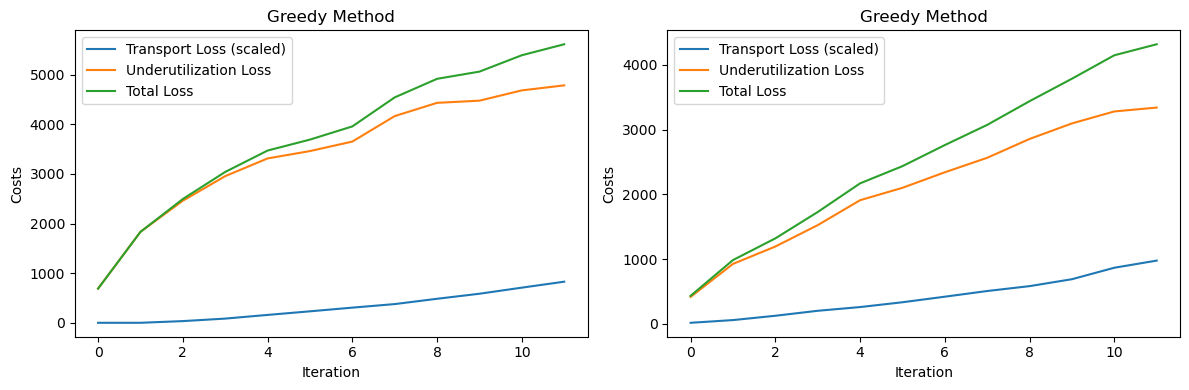

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_loss(loss_greed, ax=axes[0])
plot_loss(loss_greed_v2, ax=axes[1])
plt.tight_layout()
plt.show()

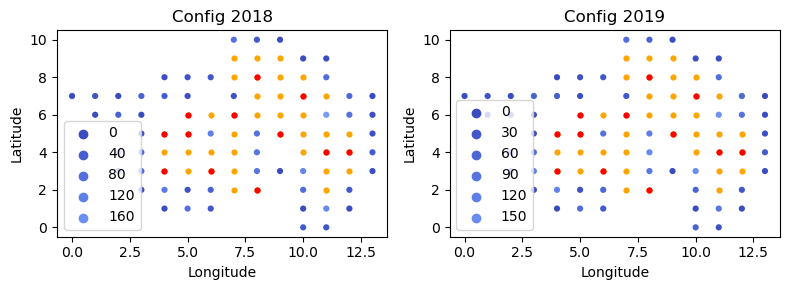

In [13]:
plot_map(dfcluster_new, used_greed, group_dict_greed)

In [27]:
used_2018 = []
depot_dict_2018 = {}
refinery_dict_2018 = {}
costs_2018 = []

avail = dfcluster_new[~dfcluster_new['Index'].isin(used_2018)]
Sites = avail['Index'].tolist()
Depots = avail['Index'].tolist()
Refinery = avail['Index'].tolist()
Biomass = avail.copy()['2018']
cap_depot = 1000
cap_refinery = 6000

In [28]:
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver initialization failed")

In [29]:
use_depot = {}
use_refinery = {}
assignment = {}

for j in Depots:
    use_depot[j] = solver.BoolVar(f"Use Depot {j}")

for k in Refinery:
    use_refinery[k] = solver.BoolVar(f"Use Depot {k}")

for i in Sites:
    for j in Depots:
        for k in Refinery:
            assignment[(i, j, k)] = solver.BoolVar(f"Assignment {i},{j},{k}")

In [ ]:
trans_cost_biomass = solver.Sum(
    Biomass[i] * df_dist_new[str(j)][int(i)]
)

In [26]:
trans_cost_biomass = solver.Sum(
    df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
    for i in Sites for j in Depots
)

under_cost_depot = solver.Sum(
    cap_depot * use_depot[j] - solver.Sum(
        Biomass[i] * assign_depot[i, j] for i in Sites
    ) for j in Depots
)

Pellets = [solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) for j in Depots]

trans_cost_pellets = solver.Sum(
    df_dist_new[str(k)][int(j)] * Pellets[j] * assign_refinery[j, k]
    for j in Depots for k in Refinery
)

under_cost_refinery = solver.Sum(
    cap_refinery * use_refinery[j] - solver.Sum(
        Pellets[j] * assign_refinery[j, k] for j in Depots
    ) for k in Refinery
)

TypeError: 

In [ ]:
trans_cost = solver.Sum(
    df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
    for i in Sites for j in Depots
)

under_cost = solver.Sum(
    cap * use_depot[j] - solver.Sum(
        Biomass[i] * assign_depot[i, j] for i in Sites
    ) for j in Depots
)

In [ ]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []

avail = dfcluster_new[~dfcluster_new['Index'].isin(used_2018)]
max_iter = 30
maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
Sites = avail['Index'].tolist()
Depots = avail['Index'].tolist()
Biomass = avail.copy()['2018']
cap = 1000

solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver initialization failed")

use_depot = {}
assign_depot = {}

for j in Depots:
    use_depot[j] = solver.BoolVar(f"Use Depot {j}")

for i in Sites:
    for j in Depots:
        assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

trans_cost = solver.Sum(
    df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
    for i in Sites for j in Depots
)

under_cost = solver.Sum(
    cap * use_depot[j] - solver.Sum(
        Biomass[i] * assign_depot[i, j] for i in Sites
    ) for j in Depots
)

total_cost = trans_cost*0.001 + under_cost
solver.Minimize(total_cost)

solver.Add(solver.Sum(use_depot[j] for j in Depots) == 12)

for i in Sites:
    for j in Depots:
        solver.Add(assign_depot[i, j] <= use_depot[j])

for j in Depots:
    solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
    # solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

for i in Sites:
    solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

status = solver.Solve()

In [20]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []

avail = dfcluster_new[~dfcluster_new['Index'].isin(used_2018)]
max_iter = 30
maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
Sites = avail['Index'].tolist()
Depots = avail['Index'].tolist()
Biomass = avail.copy()['2018']
cap = 1000

solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver initialization failed")

use_depot = {}
assign_depot = {}

for j in Depots:
    use_depot[j] = solver.BoolVar(f"Use Depot {j}")

for i in Sites:
    for j in Depots:
        assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

trans_cost = solver.Sum(
    df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
    for i in Sites for j in Depots
)

under_cost = solver.Sum(
    cap * use_depot[j] - solver.Sum(
        Biomass[i] * assign_depot[i, j] for i in Sites
    ) for j in Depots
)

total_cost = trans_cost*0.001 + under_cost
solver.Minimize(total_cost)

solver.Add(solver.Sum(use_depot[j] for j in Depots) == 12)

for i in Sites:
    for j in Depots:
        solver.Add(assign_depot[i, j] <= use_depot[j])

for j in Depots:
    solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
    # solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

for i in Sites:
    solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

status = solver.Solve()
losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
costs_2018.append(losses)

variable_values = {
    var.name(): var.solution_value() for var in [use_depot[j] for j in Depots] +
    [assign_depot[i, j] for i in Sites for j in Depots]
}

group_assign_dict = {}
centers = []
for var_name, var_value in variable_values.items():
    if var_value > 0 :
        line = var_name
        if line.startswith('Assign Depot'):
            key = int(line.split(',')[1])
            value = int(line.split(',')[0].split(' ')[2])
            if key in group_assign_dict:
                group_assign_dict[key].append(value)
            else:
                group_assign_dict[key] = [value]
        else :
            centers.append(int(line.split(' ')[2]))

for value_list in group_assign_dict.values():
    used_2018.extend(value_list)

group_dict_2018.update(group_assign_dict)
print(centers, losses)

[12, 14, 32, 34, 38, 47, 54, 56, 60, 65, 80, 82] (1079.9800050441136, 603551.4313686606, 476.42857367545366)


In [ ]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []

avail = dfcluster_new[~dfcluster_new['Index'].isin(used_2018)]
max_iter = 100
maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
Sites = avail['Index'].tolist()
Depots = maxval_index
Biomass = avail.copy()['2018']
cap = 5000

solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver initialization failed")

use_depot = {}
assign_depot = {}

for j in Depots:
    use_depot[j] = solver.BoolVar(f"Use Depot {j}")

for i in Sites:
    for j in Depots:
        assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

trans_cost = solver.Sum(
    df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
    for i in Sites for j in Depots
)

under_cost = solver.Sum(
    cap * use_depot[j] - solver.Sum(
        Biomass[i] * assign_depot[i, j] for i in Sites
    ) for j in Depots
)

# Combine transportation cost and fixed cost for the total cost
total_cost = trans_cost*0.001 + under_cost
solver.Minimize(total_cost)

solver.Add(solver.Sum(use_depot[j] for j in Depots) == 6)

for i in Sites:
    for j in Depots:
        solver.Add(assign_depot[i, j] <= use_depot[j])

for j in Depots:
    solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
    # solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

for i in Sites:
    solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

status = solver.Solve()

losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
costs_2018.append(losses)

variable_values = {
    var.name(): var.solution_value() for var in [use_depot[j] for j in Depots] +
    [assign_depot[i, j] for i in Sites for j in Depots]
}

group_assign_dict = {}
centers = []
for var_name, var_value in variable_values.items():
    if var_value > 0 :
        line = var_name
        if line.startswith('Assign Depot'):
            key = int(line.split(',')[1])
            value = int(line.split(',')[0].split(' ')[2])
            if key in group_assign_dict:
                group_assign_dict[key].append(value)
            else:
                group_assign_dict[key] = [value]
        else :
            centers.append(int(line.split(' ')[2]))

for value_list in group_assign_dict.values():
    used_2018.extend(value_list)

group_dict_2018.update(group_assign_dict)
print(centers, losses)

In [ ]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []
for iter_index in tqdm(range(15), desc='Optimize'):
    avail = dfcluster_new[~dfcluster_new['Index'].isin(used_2018)]
    max_iter = 1
    maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
    Sites = avail['Index'].tolist()
    Depots = maxval_index
    Biomass = avail.copy()['2018']
    cap = 2000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    use_depot = {}
    assign_depot = {}

    for j in Depots:
        use_depot[j] = solver.BoolVar(f"Use Depot {j}")

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap * use_depot[j] - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    solver.Add(solver.Sum(use_depot[j] for j in Depots) == 1)

    for i in Sites:
        for j in Depots:
            solver.Add(assign_depot[i, j] <= use_depot[j])

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
        # solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2018.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in [use_depot[j] for j in Depots] +
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2018.extend(value_list)

    group_dict_2018.update(group_assign_dict)
    print(centers, losses)

In [ ]:
median_index = 147
median_dist = df_dist_new[str(median_index)]

depot_list = list(group_dict_2018.keys())
depot_list_sorted = median_dist[median_dist.index.isin(depot_list)].sort_values(ascending=False).index.tolist()

In [ ]:
used_2019 = [] 
group_dict_2019 = {}
costs_2019 = []
for iter_index in tqdm(range(3), desc='opt_2019') :
    print(f'Iter no: {iter_index+1}')
    Depots = depot_list_sorted[5*iter_index:5*(iter_index+1)]
    Sites = dfcluster_new[~dfcluster_new['Index'].isin(used_2019 + depot_list_sorted[5*(iter_index+1):])]['Index'].tolist()
    Biomass = dfcluster_new.copy()['2019']
    cap = 2000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    assign_depot = {}

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        df_dist_new[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap <= 0)
        solver.Add(assign_depot[j, j] == 1)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()
    print(total_cost.solution_value())

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2019.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in 
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2019.extend(value_list)

    group_dict_2019.update(group_assign_dict)

In [ ]:
costs_2018

In [ ]:
total_cost = 0
transport_cost = 0
underutil_cost = 0
for costs_ in [costs_2018, costs_2019] :
    for cost in costs_:
        total_cost += cost[0]
        transport_cost += cost[1]
        underutil_cost += cost[2]

print(f'Total cost : {total_cost}')
print(f'Total transport : {transport_cost*0.001}')
print(f'Total underutil : {underutil_cost}')

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster_new[~dfcluster_new['Index'].isin(used_2018)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster_new[~dfcluster_new['Index'].isin(used_2019)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster_new[dfcluster_new['Index'].isin(used_2018)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster_new[dfcluster_new['Index'].isin(used_2019)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster_new[dfcluster_new['Index'].isin(list(group_dict_2018.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster_new[dfcluster_new['Index'].isin(list(group_dict_2019.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()